In [36]:
import cantera as ct
import numpy as np
import pandas as pd
import os
%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
from matplotlib import pyplot as plt

from IPython.display import display, HTML

import scipy.optimize

print(f"Running Cantera Version: {ct.__version__}")

Running Cantera Version: 2.6.0


In [37]:
# Import plotting modules and define plotting preference

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 120

# Get the best of both ggplot and seaborn
plt.style.use("ggplot")
plt.style.use("seaborn-deep")
plt.rcParams["figure.autolayout"] = True

In [38]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
T_range = [T for T in range (900,1400,100)]  #Kelvin

pressure = 0.04*1e5  # constant pressure, ]Pa[]

# Define the gas-mixutre and kinetics
gas = ct.Solution("output.yaml")

composition = {"furfuryl(1)": 0.01, "He": 0.99}

# Define the components and concentrations. The names must match to thoes in your model:
# phi = 5.5/21
# composition = {"furfuryl(1)": 1, "O2(2)": 5.5/phi, "N2": 5.5*3.76/phi}

In [39]:
#PFR, paper: https://www.sciencedirect.com/science/article/pii/S1540748920305757?via%3Dihub

length = 0.22  # *approximate* PFR length, m
internal_diameter = 0.007 #m
area = np.pi*(1/4)*internal_diameter**2  # cross-sectional area, m^2
inlet_flow_rate = 0.001/60  #in my case it's 1 L/minute = 0.001 m^3/60 sec
u_0 = inlet_flow_rate/area  # inflow velocity, m/s 

In [40]:
species_list = gas.species()
#define your observables:
observables = ['furfuryl(1)']
print("The number of rxns is:",len(gas.reactions()))

The number of rxns is: 4592


In [27]:
# Set the value of the perturbation
dk = 1e-2

In [ ]:
# Resolution: The PFR will be simulated by 'n_steps' time steps or by a chain of 'n_steps' stirred reactors.
n_steps = 1000

# time in the end of the PFR!
t_total = length / u_0
print("total time is:",t_total)
dt = t_total / n_steps
# define time, space, and other information vectors
t1 = (np.arange(n_steps) + 1) * dt

# import the gas model and set the initial conditions
gas1 = gas
species = gas1.species_names

#Lagrangian Method
def solve_pfr_in_outlet (T, t1, t_total):
    gas1.TPX = T, pressure, composition
    mass_flow_rate1 = u_0 * gas1.density * area
    # Initialize reactor and reactor network
    r1 = ct.IdealGasConstPressureReactor(gas1)
    sim1 = ct.ReactorNet([r1])
    z1 = np.zeros_like(t1)
    u1 = np.zeros_like(t1)
    states1 = ct.SolutionArray(r1.thermo)
    for n1, t_i in enumerate(t1):
        # perform time integration
        sim1.advance(t_i)
        # compute velocity and transform into space
        u1[n1] = mass_flow_rate1 / area / r1.thermo.density
        z1[n1] = z1[n1 - 1] + u1[n1] * dt
        states1.append(r1.thermo.state)

for species in observables:
    sensitivities = pd.DataFrame(index=gas1.reaction_equations(), columns=T_range)
    sensitivities.to_csv(species+'_sa_results.csv')
    for T in T_range:
        solve_pfr_in_outlet(T, t1, t_total)
        baseline_concentrations = gas1.mole_fraction_dict()

        for m in range(gas1.n_reactions): #n_reactions gives the number of reaction in the mechanism
            gas1.TP = T, pressure
            gas1.set_multiplier(1.0)  # Reset multipliers

            # Perturb the rate coefficient slightly
            k_i0 = gas1.forward_rate_constants[m]
            gas1.set_multiplier(1 + dk, m)
            solve_pfr_in_outlet(T, t1, t_total)
            sensitivity = (gas1.mole_fraction_dict()[species] - baseline_concentrations[species]) * (k_i0 / ((gas1.forward_rate_constants[m] - k_i0) * baseline_concentrations[species]))
            # Store sensitivity in the DataFrame
            sensitivities.at[ gas1.reaction_equation(m), T] = sensitivity
            # Save intermediate results to CSV file in each iteration
            sensitivities.to_csv(species+'_sa_results.csv')
        #sensitivities.to_csv(species+'_sa_results.csv', mode='a', index_label=T, header=False)
    sensitivities.to_csv(species+'_sa_results_final.csv')        
gas1.set_multiplier(1.0)

In [41]:
import arc.rmgdb as rmgdb
from arc.reaction import ARCReaction
from rmgpy.chemkin import load_species_dictionary
import rmgpy.data.kinetics.family as family
from rmgpy.species import Species
from rmgpy.reaction import Reaction

In [ ]:
#Load kinetic families only from rmgdb
rmg_database = rmgdb.make_rmg_database_object()
rmgdb.load_rmg_database(rmg_database)
label_adj_dict = load_species_dictionary('species_dictionary.txt')

In [45]:
def fix_stoich(reactants):
#2x +Y <=> 3Z ,in rmg --> reactants=[X,X,Y], products=[Z,Z,Z]
    i = 0
    while i < len(reactants):
        if reactants[i].isdigit():  
            multiplier = int(reactants[i]) 
            if i + 1 < len(reactants):  
                reactant = reactants[i + 1]
                repeated_reactant = [reactant] * (multiplier-1) #since one occurance already exists
                reactants[i + 1:i + 1] = repeated_reactant
            del reactants[i]
        else:
            i += 1
    return(reactants)

In [46]:
def get_rxn(rxn_label, label_adj_dict, rmg_database):
    label_splits = rxn_label.split(' <=> ')
    reactants = label_splits[0].split(' + ')
    reactants = [i.split(' ') for i in reactants]
    reactants = [value for sublist in reactants for value in sublist]
    reactants = fix_stoich(reactants)
    products = label_splits[1].split(' + ')
    products = [i.split(' ') for i in products]
    products = [value for sublist in products for value in sublist]
    products = fix_stoich(products)
    reactants = [label_adj_dict[label] for label in reactants]
    products = [label_adj_dict[label] for label in products]
    rxn_rmg = Reaction(reactants=reactants , products=products)
    family = rmgdb.determine_reaction_family(reaction = rxn_rmg, rmgdb=rmg_database)
    try:
        family = family[0].label
    except:
        family = 'None'
    return rxn_rmg, family

In [47]:
def get_rxn_dict(rxns, species, label_adj_dict ,T, rmg_database):
    # rxns_dict = {'rxn_label': {'rmg_rxn': rxn_rmg, 'family': rxn_rmg', 'img_path' = img_output_path}}
    rxns_dict = {}
    for i,rxn in enumerate(rxns):
        rmg_rxn, family = get_rxn(rxn, label_adj_dict, rmg_database)
        img_output_path = os.path.join(os.getcwd(),species, T,f"rxn_{i+1}.png")
        os.makedirs(os.path.dirname(img_output_path), exist_ok=True)
        rxns_dict [rxn] = {'rmg_rxn': rmg_rxn, 'family': family, 'img_path':img_output_path }
        rmg_rxn.draw(img_output_path)
    return rxns_dict

In [48]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def add_images_to_plot(ax, top_reactions, rxns_dict):
    # Load image for each reaction in top_reactions
    for i, reaction in enumerate(top_reactions):
        img_path = rxns_dict[reaction]['img_path']
        img = plt.imread(img_path)

        imagebox = OffsetImage(img, zoom=0.4)  
        ab = AnnotationBbox(imagebox, (-0.35, i+0.5), frameon=False, xycoords=('axes fraction', 'data'))

        # Add image to plot
        ax.add_artist(ab)

        # Add title as annotation text with smaller font size and above the image
        title_text = rxns_dict[reaction]['family']
        ax.annotate(title_text, xy=(1, i), xycoords=('axes fraction', 'data'),
                    xytext=(5,0), textcoords='offset points', fontsize=8,
                    color='black', va='center', ha='left')


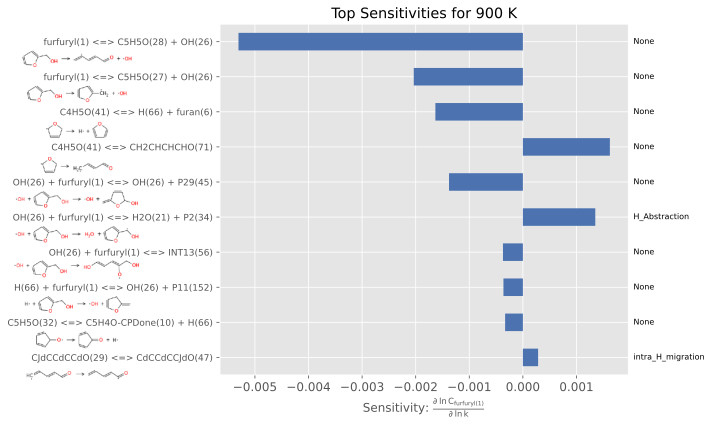

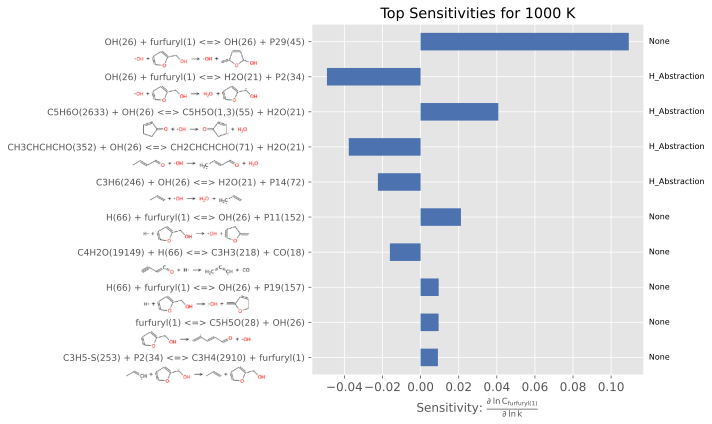

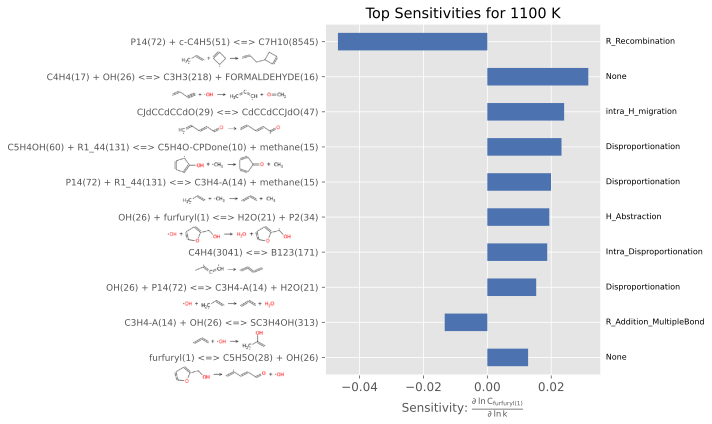

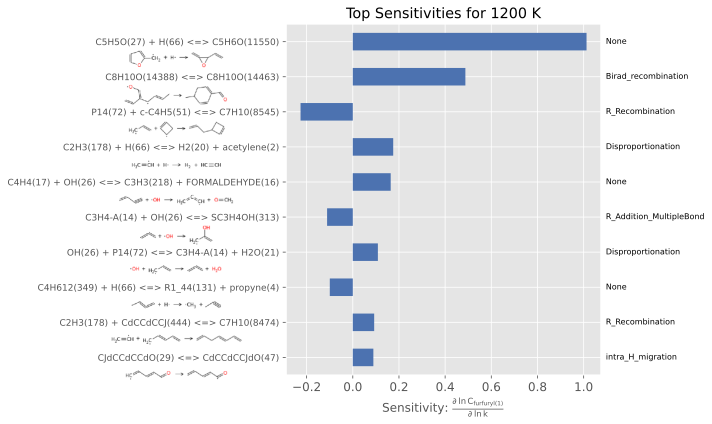

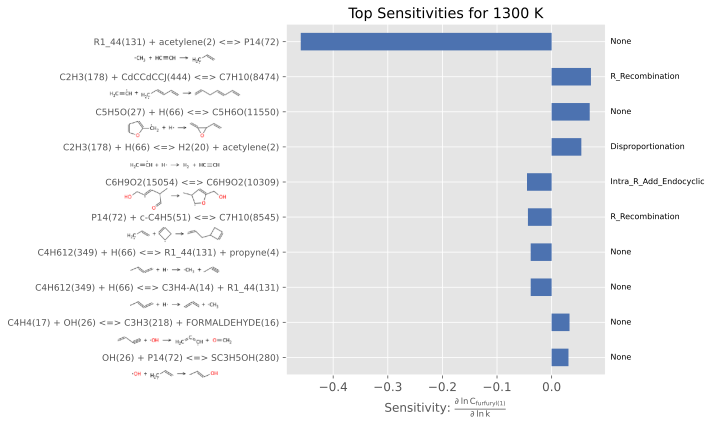

In [49]:
top_n = 20  # Number of top values to consider (double the number in case there is a duplicate to each rxn)
for species in observables:
    file_name = species + '_sa_results_final.csv'
    if os.path.exists(file_name):
        sensitivities = pd.read_csv(file_name, index_col=0) #rxns equesions are the rows IDs
        temperatures = sensitivities.columns  # column indices
        for T in temperatures:
            sensitivities_T = sensitivities.loc[:, T]
            # Sort absolute values and select top 10
            top_sensitivities = sensitivities_T.abs().nlargest(top_n).drop_duplicates(keep='first')
            top_sensitivities = top_sensitivities.head(int(top_n/2))
            # Get rxns equations (meaning, the rows' indices of the top sensitivities)
            top_reactions = top_sensitivities.index
            rxns_dict = get_rxn_dict(top_reactions, species, label_adj_dict, T, rmg_database)
            
            fig, ax = plt.subplots(figsize= (10,6))
            sensitivities_subset = sensitivities.loc[top_reactions, T].drop_duplicates(keep='first')
            sensitivities_subset.plot.barh(ax=ax, title=f"Top Sensitivities for {T} K", legend=None)
            ax.set_yticks(range(len(top_reactions)))
            ax.set_yticklabels(top_reactions, fontsize=9)
            ax.invert_yaxis()
            ax.set_xlabel(f"Sensitivity: $\\frac{{\\partial\\:\\ln{{C_{{{species}}}}}}}{{\\partial\\:\\ln{{k}}}}$")
            add_images_to_plot(ax, top_reactions, rxns_dict)
            plt.tight_layout()
            plt.savefig(f"{species}_{T}K_sa_top10.png", dpi=300)
            plt.show()